In [2]:
import numpy as np
import sympy as sy
import sympy.physics.mechanics as me
import matplotlib.pyplot as plt

## Enunciado

<p style="text-align: justify;">
Uma placa de espessura L possui uma distribuição linear de temperatura no seu interior, de T = T₀ em x = 0 a T = Tₗ em x = L. No instante t = 0, a face em x = L é isolada termicamente, enquanto a face em x = 0 continua sendo mantida a T = T₀. Calcule a distribuição adimensional de temperatura (T – T₀)/(Tₗ – T₀) em função de x/L e de αt/L², onde α indica a difusividade térmica do material da placa. Continue o cálculo até que o valor de (T – T₀)/(Tₗ – T₀) em x = L caia abaixo de 0,5.
</p>



In [3]:
x, alpha = sy.symbols('x alpha')
t = me.dynamicsymbols._t
T = sy.Function('T')(x, t)

## Modelagem física

Partindo da equação da condução levando em consideração as seguintes hipótese:

- Regime transiente;
- Condução de calor unidimensional;
- Propriedades constantes.

Pode-se escrever a seguinte equação para a condução de calor:

In [4]:
eq_cond = sy.Eq(alpha * sy.diff(T,x,2),(sy.diff(T,t,1)))
eq_cond

Eq(alpha*Derivative(T(x, t), (x, 2)), Derivative(T(x, t), t))

onde:

- $T$ é a temperatura;

- $t$ é o tempo;

- $x$ é a posição;

- $\alpha$ é a difusividade térmica definido como $\alpha = k / (\rho c_p)$.

E, conforme o enunciado, sabemos que inicialmente a distribuição de temperatura no interior da placa apresenta um perfil linear, assim:

$$T(x,0) = T_0 + (T_L - T_0) \frac{x}{L} $$

Além disso, temos as seguintes condições de contorno:

| Condições de Contorno | Localização | Condição Dimensional |
|-----------------------|-------------|----------------------|
| Dirichlet             | x = 0       | $T(0,t)$ = $T_0$ (Temperatura constante)               |
| Neumann               | x = L       | $\frac{\partial T}{\partial x}$ (L,t) = 0 (isolamento térmico)            |

Entretanto resolver essa equação analiticamente não é trivial, de forma que é necessário fazer uso de variáveis adimensionais para facilitar os cálculos.

## Formulação adimensional

A fim de generalizar a solução, adimensionalizar-se-á o problema utilizando as seguintes variáveis:

**- Temperatura adimensional:** $\Theta = \frac{T - T_0}{T_L - T_0}$;

**- Posição adimensional:** $X = \frac{x}{L}$

**- Tempo adimensional (Número de Fourier):** $Fo = \frac{\alpha t}{L^2}$

Substituindo essas variáveis na esquação governantes, obtemos a seguinte forma adimensional:

In [5]:
Fo, X = sy.symbols('Fo X')
theta = sy.Function('Theta')(Fo, X)

In [6]:
eq_cond_adimen = sy.Eq(sy.diff(theta,Fo,1),sy.diff(theta,X,2))
eq_cond_adimen

Eq(Derivative(Theta(Fo, X), Fo), Derivative(Theta(Fo, X), (X, 2)))

Rearranjando a equação $T(x,0) = T_0 + (T_L - T_0) \frac{x}{L}$, a condição inicial em termos adimensionais passa a ser:

$\Theta (X, Fo = 0) = X $

Portanto, inicialmente, a temperatura adimensional $\Theta$ é igual à posição adimensional $X$.


Enquanto as condições de contorno em termos adimensionais tornam-se:

| Condições de Contorno | Localização | Condição Dimensional |
|-----------------------|-------------|----------------------|
|Dirichlet| X = 0 | $\Theta(0, Fo) = 0 $|
|Neumann| X = 1| $\frac{\partial{\Theta}}{\partial{X}} (1,Fo) = 0$| 


### Discretização pelo Método dos Volumes Finitos (MVF)

A formulação padrão para o  **Esquema Totalmente Implícito (f = 1)**, a equação discretizada assime a forma:

$$a_P \Theta_P = a_W\Theta_W + a_E\Theta_{E} + b_P$$

Onde os coeficientes são:

| Coeficiente | Expressão |
|---| ---|
| $a_W$ | $\frac{1}{\Delta X^2}$ |
| $a_E$ | $\frac{1}{\Delta X^2} $|
|  $a_P$ | $a_W + a_E + \frac{1}{\Delta Fo}$ |
| $b_P$ | $\frac{1}{\Delta Fo} \Theta_P^0$ |

Onde $\Delta X$ é o passo espacial e $\Delta Fo$ é o passo temporal adimensional e o superescrito "0" indica no tempo anterior.

### Discretização das condições de contorno

**1. Contorno em $X = 0$ (Dirichlet):** O primeiro ponto nodal é mantido a $\Theta_0 = 0$. Dessa forma, a equação discretizada para o nó 2 é expressa por:

$$a_2 T_2 = b_2 T_3 + d_2$$

onde:

- $b_2 = \frac{1}{\Delta X^2}$;

- $c_2 = 0$;

- $a_2 = b_2 - (S_{PA} \cdot \Delta X) + \frac{1}{\Delta Fo}$;

- $d_2 = S_{CA} \cdot \Delta X + \left(\frac{1}{\Delta Fo}\right) \cdot \Theta_2^0$;

- $S_{PA} = - \left(\frac{1}{\Delta X /2}\right) \cdot \Delta X \,\,\,\,\,\, \text{e} \,\,\,\,\,\, S_{CA} = \left(\frac{\Theta_0}{\Delta X/2}\right) \cdot \Delta X .$

**2. Contorno em $X = 1$ (Neumann):** Utiliza-se a equação discretizada para o ponto nodal N - 1:

$$a_{N - 1}\Theta_{N-1} = a_W \Theta_{N-2} + b_{N-1}$$


Onde:
- $a_w = \frac{1}{\Delta X^2}$;

- $a_{N-1} = \frac{1}{\Delta X^2} + \frac{1}{2 \Delta Fo}$;

- $b_{N-1} = \frac{1}{2 \Delta Fo} \Theta_{N-1}^0$

In [7]:
# Parâmetros do problema
L = 1

In [8]:
# Definindo os parâmetros da malha

nv = 20          # Número de volumes de controle
n_nos = nv + 2   # Total de nós (incluindo os de contorno)
dx = L / nv      # Comprimento entre os volumes de controle centrais

print(f'O comprimento adimensional do volume de controle dos nós centrais é {dx} e dos nós de fronteira é {dx/2}. ')


O comprimento adimensional do volume de controle dos nós centrais é 0.05 e dos nós de fronteira é 0.025. 


Text(0.5, 0, 'Posição do nó')

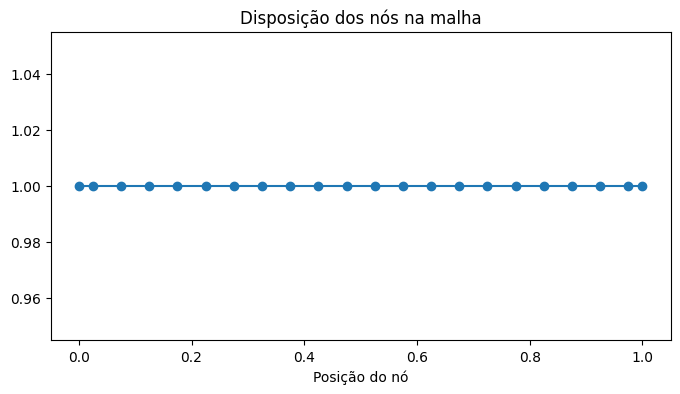

In [9]:
# Criando a malha conforme a prática 2

x_nodes = np.zeros(n_nos)             # Vetor vazio que conterá as posições dos nós
x_nodes[0] = 0                        # Posição do primeiro nó (CC)
x_nodes[1] = dx/2                     # Posição do segundo nó (primeiro nó de fronteira)
for i in range (2, n_nos - 2):        # Nós centrais
    x_nodes[i] = (dx/2) + ((i-1)*dx)
x_nodes[n_nos - 2] = L - (dx/2)       # Posição do penúltimo nó
x_nodes[n_nos - 1] = L                # Posição do último nó
teste = np.full(len(x_nodes),1)

plt.figure(figsize=(8,4))
plt.title('Disposição dos nós na malha')
plt.plot(x_nodes, teste, 'o-')
plt.xlabel("Posição do nó")

In [10]:
# Condição inicial (CI): Theta(X, 0) = X
Theta = x_nodes.copy()   # No começo a distrinuição adimensional da temperatura é igual à posição adimensional, condizente com a suposição de perfil linear
Theta_old = Theta.copy() # Temperatura do passo anterior (necessária para a implementação do método implícito)

In [11]:
# Parâmetros temporais
dFo = 0.1 * dx  # Passo de tempo adimensional (número de Fourier) -> foi escolhido 0.1 * dx para garatia de estabilidade numérica
Fo = 0          # Tempo adimensnal atual (começa em zero)

In [12]:
# Coeficientes constantes do método Implícito (f = 1)
aw = ae = 1 / dx**2
ap = aw + ae + (1/dFo)

In [13]:
# Loop de tempo
results = []     # Armazena os resultados de Theta em X = 1
iterations = 0   # Contador de passos no tempo

In [14]:
# Criando um loop para executar a simulação enquanto Theta estiver acima de 0.5  0.5, não 

while Theta[n_nos - 2] >= 0.5:
    # Vetores da matriz TDMA
    a = np.zeros(n_nos)  # Diagonal principal
    b = np.zeros(n_nos)  # Subdiagonal (vizinha esquerda)
    c = np.zeros(n_nos)  # Superdiagonal (vizinha direita)
    d = np.zeros(n_nos)  # Lado direito 

    # Nó 2 (primeiro no interno) - CC em X = 0: Theta(0, Fo) = 0
    # Cálculo dos parâmetros do nó 2
    Theta_left = 0
    Sca_2 = (Theta_left / ((dx**2)/2)) / dx
    Spa_2 = - (1 / ((dx**2)/2)) / dx

    # Coeficientes da matriz de Thomas do nó 2
    a[1] = (1/dx**2) - (Spa_2 * dx) + (1 / dFo)
    b[1] = 0 # Não há vizinho à esquerda
    c[1] = 1 / dx**2
    d[1] = Sca_2 * dx + (1 / dFo) * Theta_old[1]

    # Cúlculo dos coeficientes da matriz de Thomas nos nós centrais (de 2 até n - 2)
    for i in range(2, n_nos - 2):
        a[i] = (ae + aw + (1 / dFo))
        b[i] = aw
        c[i] = ae
        d[i] = (1 / dFo) * Theta_old[i]

    # Cálculo dos coeficientes do penúltimo nó (último nó interno) - CC em X = 1: dTheta/dX = 0 (Neumann)
    c[n_nos - 2] = 0
    b[n_nos - 2] = 1 / dx**2
    a[n_nos - 2] = (1 / (dx**2)) + (1 / (2 * dFo))
    d[n_nos - 2] = (1 / (2*dFo)) * Theta_old[n_nos - 2]


    # Algoritmo TDMA
    P = np.zeros(n_nos)
    Q = np.zeros(n_nos)
    Theta_new = Theta.copy()

    # Passo 1 
    P[1] = c[1] / a[1]
    Q[1] = d[1] / a[1]

    for i in range(2, n_nos - 1):
        denom = a[i] - (b[i] * P[i - 1])
        P[i] = c[i] / denom
        Q[i] = (d[i] + b[i] * Q[i - 1]) / denom

    Theta_new[n_nos - 2] = Q[n_nos - 2]

    for i in range(n_nos - 3, 0, -1):
        Theta_new[i] = P[i] * Theta_new[i + 1] + Q[i]

    Theta_new[0] = 0
    Theta_new[n_nos - 1] = Theta_new[n_nos - 2] # CC de Neuman

    # Atualizar
    Theta_old = Theta_new.copy()
    Theta = Theta_new.copy()
    Fo += dFo
    iterations += 1

    # Armazenar resultado de interesse: Theta em X=1 (último nó interno)
    results.append([Fo, Theta[n_nos - 2]])   

In [15]:
# DEPOIS DO LOOP (fora do while):
results = np.array(results)
Fo_final = Fo

print(f"Iterações: {iterations}")
print(f"Fo final: {Fo_final:.4f}")
print(f"Theta final em X=1: {Theta[n_nos - 2]:.4f}")

Iterações: 36
Fo final: 0.1800
Theta final em X=1: 0.4989


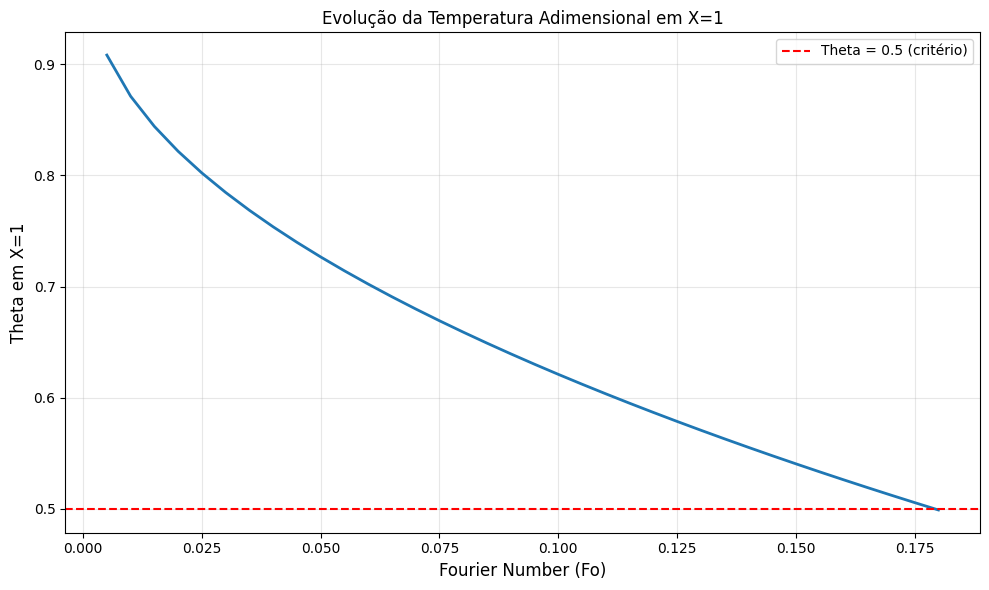

In [18]:
# Plotar evolução de Theta em X=1
plt.figure(figsize=(10, 6))
plt.plot(results[:, 0], results[:, 1], '-', linewidth=2)  # ← CORRIGIDO
plt.axhline(y=0.5, color='r', linestyle='--', label='Theta = 0.5 (critério)')
plt.xlabel('Fourier Number (Fo)', fontsize=12)
plt.ylabel('Theta em X=1', fontsize=12)
plt.title('Evolução da Temperatura Adimensional em X=1')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('theta_evolution.png', dpi=300)
plt.show()

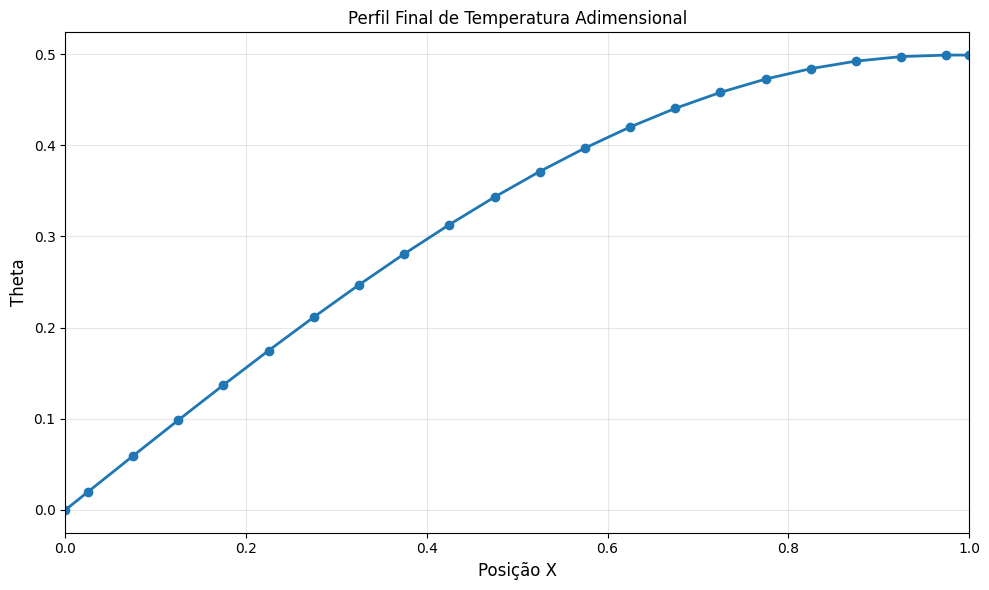

In [17]:
# Plotar perfil final de temperatura
plt.figure(figsize=(10, 6))
plt.plot(x_nodes, Theta, 'o-', linewidth=2, markersize=6) 
plt.xlabel('Posição X', fontsize=12)
plt.ylabel('Theta', fontsize=12)
plt.title('Perfil Final de Temperatura Adimensional')
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.tight_layout()
plt.savefig('final_profile.png', dpi=300)
plt.show()